### House Prices

* [Kaggle Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt)

### Getting Started

In [28]:
#Imports
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

#Statistics
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

#Float Output to 2 decimals
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

#Models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Importing datasets

In [29]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [30]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [31]:
#Saving then dropping Id column as it does not impact our prediction
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

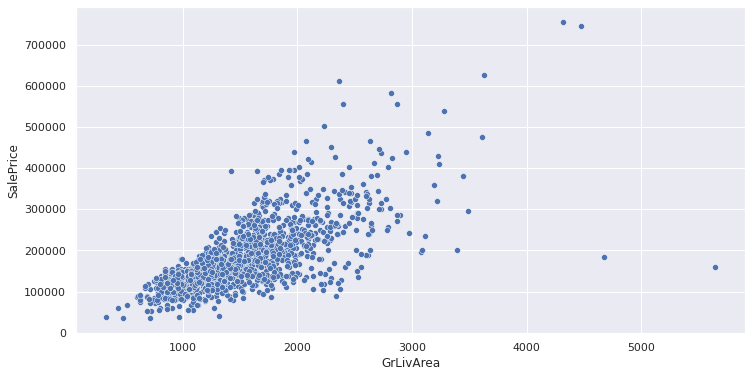

In [32]:
#visualizing outliers
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

In [33]:
#from above prediction we are removing outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

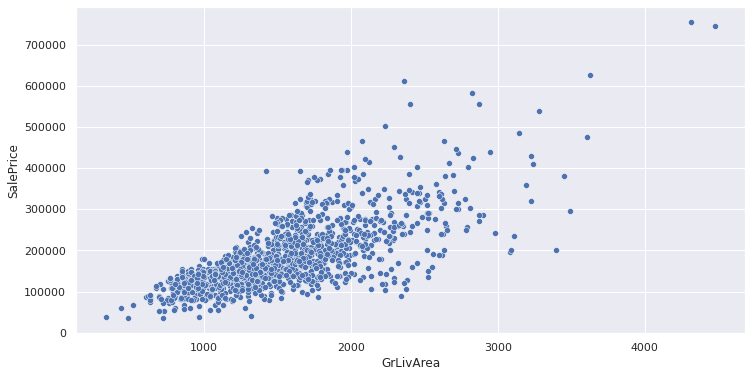

In [34]:
#again visualizing outliers
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


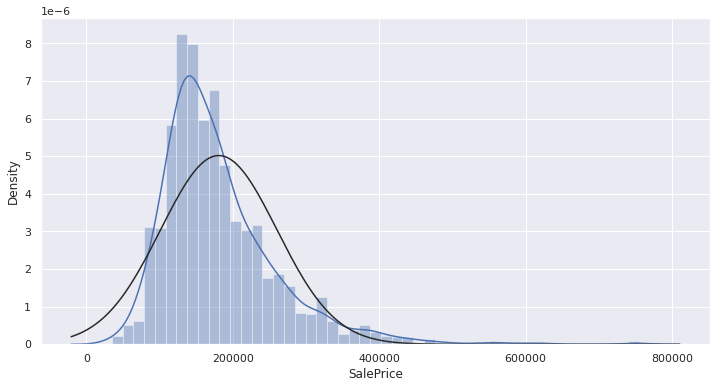

In [35]:
sns.distplot(train['SalePrice'] , fit=norm)

From we can tell it is right skewed so to make it fall in to GD we can do log transformation for it

In [36]:
#Fitted parameters used by function
(mu, sigma) = norm.fit(train['SalePrice'])

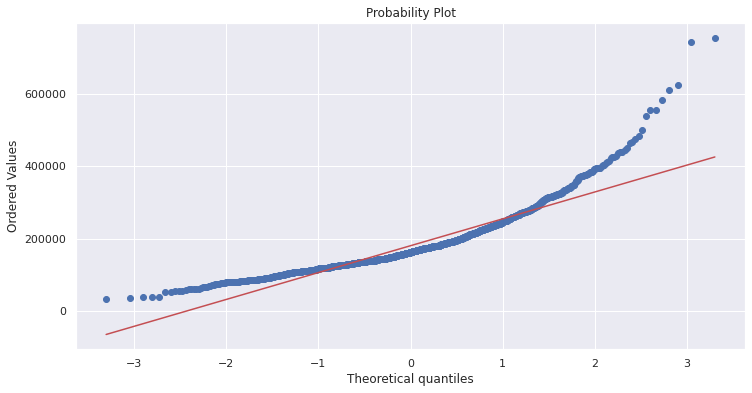

In [37]:
#Visualize Quantile-Quantile plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


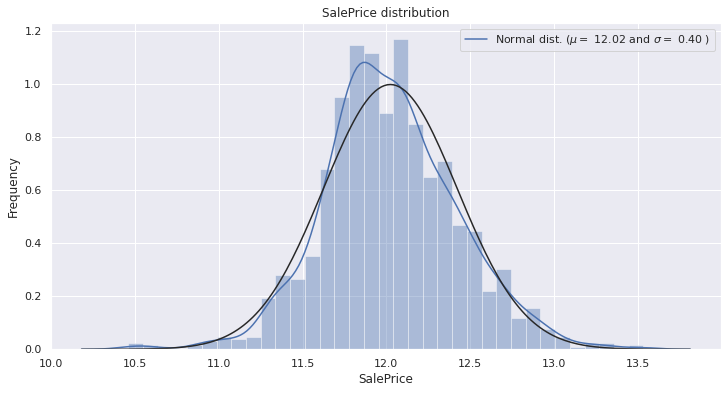

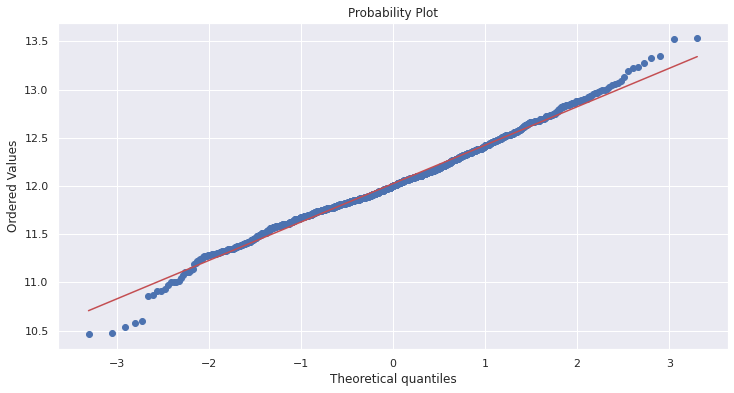

In [38]:
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm)


#Fitted parameters used by function
(mu, sigma) = norm.fit(train['SalePrice'])

#Visualize Normal Distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Visualize Quantile-Quantile plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

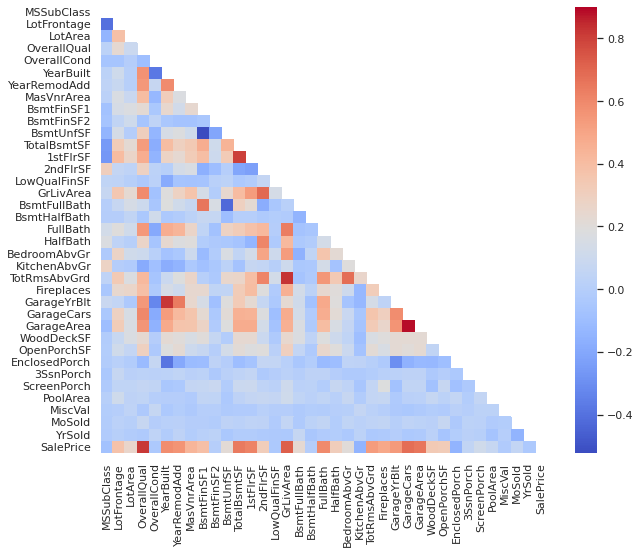

In [39]:
#Correlation map to understand how other features relate to SalePrice
corrmat = train.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmat, mask=mask, ax=ax, cbar_kws={"shrink": .82},vmax=.9, cmap='coolwarm', square=True)

In [40]:
#Creating index for splitting datasets
i_train = train.shape[0]
i_test = test.shape[0]

#Setting y_train
y_train = train.SalePrice.values

#Concatenating datasets
df_concat = pd.concat((train, test)).reset_index(drop=True)
df_concat.drop(['SalePrice'], axis=1, inplace=True)

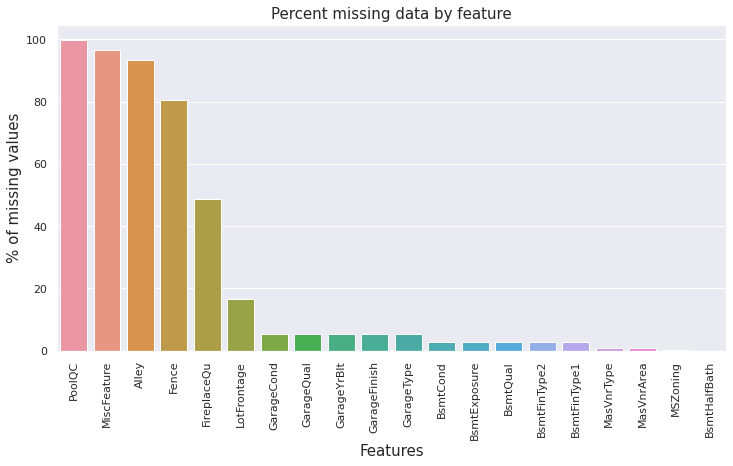

In [41]:
#Creating dataframe with percentages of missing values
nullValues = (df_concat.isnull().sum() / len(df_concat)) * 100

#Sorting by percentages of missing values
nullValues = nullValues.sort_values(ascending=False)[:20] #values of missing percentages after index 20 drop to around 0.03.. 

missing_values = pd.DataFrame({'Missing %' :nullValues})

#Visualizing missing values by feauture
sns.barplot(x=nullValues.index, y=nullValues)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('% of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);


In [42]:
df_concat['PoolQC'].fillna('None', inplace=True)
df_concat['MiscFeature'].fillna('None', inplace=True)
df_concat['Alley'].fillna('None', inplace=True)
df_concat['Fence'].fillna('None', inplace=True)
df_concat['FireplaceQu'].fillna('None', inplace=True)
df_concat['MasVnrType'].fillna('None', inplace=True)
df_concat['MasVnrArea'].fillna(0, inplace=True)
df_concat['MSZoning'].fillna('RL', inplace=True)
df_concat['Functional'].fillna('Typ', inplace=True)
df_concat['Electrical'].fillna('SBrkr', inplace=True)
df_concat['KitchenQual'].fillna('TA', inplace=True)
df_concat['Exterior1st'].fillna('TA', inplace=True)
df_concat['Exterior2nd'].fillna('TA', inplace=True)
df_concat['SaleType'].fillna('WD', inplace=True)

In [43]:
df_concat["LotFrontage"] = df_concat.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [44]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_concat[col].fillna('None', inplace=True)

In [45]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_concat[col].fillna(0, inplace=True)

In [46]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):    
    df_concat[col].fillna('None', inplace=True)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath'):
    df_concat[col].fillna(0, inplace=True)

In [47]:
df_concat.drop(['Utilities'], axis=1, inplace=True)

In [48]:
df_concat_na = (df_concat.isnull().sum() / len(df_concat)) * 100

df_concat_na = df_concat_na.sort_values(ascending=False) 

missing_values = pd.DataFrame({'Missing %' :df_concat_na})
missing_values.head()


,Missing %
SaleCondition,0.00
BsmtQual,0.00
Exterior1st,0.00
Exterior2nd,0.00
MasVnrType,0.00


In [49]:
#MSSubClass
df_concat['MSSubClass'].astype(str)


#Changing OverallCond into a categorical variable
df_concat['OverallCond'] = df_concat['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df_concat['YrSold'] = df_concat['YrSold'].astype(str)
df_concat['MoSold'] = df_concat['MoSold'].astype(str)
#List of features to encode
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

#Applying LabelEncoder to categorical features
for i in cols:
    le = LabelEncoder() 
    le.fit(list(df_concat[i].values)) 
    df_concat[i] = le.transform(list(df_concat[i].values))

df_concat['TotalSF'] = df_concat['TotalBsmtSF'] + df_concat['1stFlrSF'] + df_concat['2ndFlrSF']

In [50]:
numeric_feats = df_concat.dtypes[df_concat.dtypes != "object"].index

#Check the skew of all numerical features
skewed_feats = df_concat[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness.Skew)>0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #df_concat[feat] += 1
    df_concat[feat] = boxcox1p(df_concat[feat], lam)

In [51]:
df_concat = pd.get_dummies(df_concat)
#Creating new training and test sets

train = df_concat[:i_train]
test = df_concat[i_train:]

#Modelling
#Creating cross validation strategy with shuffle
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
#LASSO Regression

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=0))
#Elastic Net Regression

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=0))
#Kernel Ridge Regression

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#Gradient Boosting

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)
#XGBoost

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =0, nthread = -1,
                             verbosity = 0)
#LightGBM

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                              verbose_eval = -1)
#Model Scores
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))



Lasso score: 0.1102 (0.0072)

ElasticNet score: 0.1102 (0.0073)

Kernel Ridge score: 0.1772 (0.0053)

Gradient Boosting score: 0.1168 (0.0076)

Xgboost score: 0.1155 (0.0061)

LGBM score: 0.1175 (0.0062)



In [52]:
class AverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #Define clones of original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        #Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Predictions for cloned models and get average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [53]:
averaged_models = AverageModels(models = (lasso, ENet, GBoost, KRR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1134 (0.0081)



In [54]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    #Fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        #Train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Predictions of all base models on test data and use the averaged predictions as 
    #meta-features for the final prediction
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
#Stacking Averaged Models Score

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

#Ensembling StackedRegressor, XGBoost and LightGBM

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
#Stacked Regressor

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

Stacking Averaged models score: 0.1076 (0.0076)
0.07937365819356386


In [55]:
#XGBoost

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

#LightGBM

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0789239342740206
0.07269522276205832


In [56]:
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

#Ensemble Prediction

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

0.07631629526919591
